# **CBB Statistics**
### Final Project Notebook

### **Hypothesis:**
- *Null Hypothesis:* Tournament grouping is not predictable from season statistics.
- *Alternative Hypothesis:* Tournament grouping is predictable from season statistics.

## Imports

In [1]:
#imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import shapiro, kruskal, chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


## **Dataset**

*explaination of dataset*

In [2]:
basketball_df = pd.read_csv('cbb.csv')
basketball_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


In [3]:
# Basketball dataset with only numerical columns
basketball_df_numerical = basketball_df.select_dtypes(include='number')
basketball_df_numerical.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR
0,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,...,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1.0,2016
1,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,...,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1.0,2015
2,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,...,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3.0,2018
3,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,...,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3.0,2019
4,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,...,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1.0,2017


**Categorizing the variables into numerical and categorical**

In [4]:
numerical_vars = ["G", "W", "ADJOE", "ADJDE", "BARTHAG", "EFG_O", "EFG_D", "TOR", "TORD", 
                  "ORB", "DRB", "FTR", "FTRD", "2P_O", "2P_D", "3P_O", "3P_D", "ADJ_T", "WAB"]
categorical_vars = ["CONF", "POSTSEASON", "SEED", "YEAR"]

## **Data Preprocessing**

*short explaination of what we did here* 

identification of required features, proper handling of missing
values (removal, imputation, etc.), and supporting documentation for your decisions
such as the number of missing values relative to the size of the dataset.

##### **Missing Values Check** 

Both the Seed and Postseason columns are missing the same amount of values that make up 80.7% of there entires. The missing values occur because the majority of teams don't make the NCAA Tournament. Since only qualifying teams are assigned a tournament seed and have postseason results, the absence of data in these columns is intentional and meaningful. Therefore, for this case, these are no truly "missing" values. For the analysis, these values were replaces with "No Tournament" in Postseason and "None" in Seed.

In [5]:
#Check for missing values
missing_counts = basketball_df.isnull().sum()
missing_percent = (missing_counts / len(basketball_df)) * 100
missing_values = pd.DataFrame({
    'Missing Count': missing_counts, 
    '% Missing': missing_percent
    })
missing_values.head(len(missing_values))

,Missing Count,% Missing
TEAM,0,0.000000
CONF,0,0.000000
G,0,0.000000
W,0,0.000000
ADJOE,0,0.000000
ADJDE,0,0.000000
BARTHAG,0,0.000000
EFG_O,0,0.000000
EFG_D,0,0.000000
TOR,0,0.000000


In [6]:
#replace missing values
basketball_df['SEED'] = basketball_df['SEED'].fillna("None")
basketball_df['POSTSEASON'] = basketball_df['POSTSEASON'].fillna("No Tournament")
basketball_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


##### **Scale Numerical Features**

In [7]:
scaler = StandardScaler()
basketball_df[numerical_vars] = scaler.fit_transform(basketball_df[numerical_vars])
basketball_df.head(len(basketball_df))

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,2.407925,2.588173,2.773838,-1.267573,1.798002,0.881130,-0.686500,-1.566916,...,-0.688346,1.408147,-1.413912,-0.544408,0.751759,1.282537,2.374116,2ND,1.0,2016
1,Wisconsin,B10,2.407925,3.044657,3.572315,-1.467233,1.886916,1.595864,-0.824691,-2.992893,...,-1.939157,1.672860,-1.383761,0.848146,1.285596,-2.728767,2.770300,2ND,1.0,2015
2,Michigan,B10,2.407925,2.588173,1.548589,-1.958704,1.736898,1.303473,-0.824691,-2.232372,...,-0.750886,1.643447,-0.750571,0.371746,-0.480172,-0.593718,2.124666,2ND,3.0,2018
3,Texas Tech,B12,1.901727,2.283849,1.658723,-2.757345,1.862631,1.173521,-2.448428,-0.473666,...,0.281033,1.084609,-2.228014,0.848146,-1.917426,-0.076130,2.139340,2ND,3.0,2019
4,Gonzaga,WCC,2.154826,3.196819,2.016661,-2.588402,1.875165,2.180646,-3.104833,-1.186655,...,-1.235576,2.114049,-2.800900,1.471131,-2.204877,1.217839,2.242054,2ND,1.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518,Toledo,MAC,0.889331,1.675203,2.305765,0.990122,0.951161,2.083183,0.971785,-2.422502,...,-1.141765,1.614035,0.847480,2.020823,0.710695,0.570854,0.936113,No Tournament,None,2023
3519,Liberty,ASun,0.636232,1.675203,1.135583,-0.898970,1.294676,1.823279,-0.271929,-1.281720,...,-1.094859,2.143461,-0.207837,0.811500,-0.315915,-1.078956,0.818725,No Tournament,None,2023
3520,Utah Valley,WAC,0.889331,1.827365,0.543609,-1.313648,1.223779,0.588739,-2.102952,0.286855,...,-0.954143,0.996371,-1.956647,-0.287885,-1.342525,0.667902,1.068175,No Tournament,None,2023
3521,UAB,CUSA,1.901727,1.979526,1.273252,-0.945045,1.375756,0.133908,-0.962881,-0.663797,...,-0.922873,-0.091894,-0.629963,0.518330,-1.137203,0.959045,1.038828,No Tournament,None,2023


## **Data analysis and visualization** 

Quantitative (statistical) and visual analysis of your data.

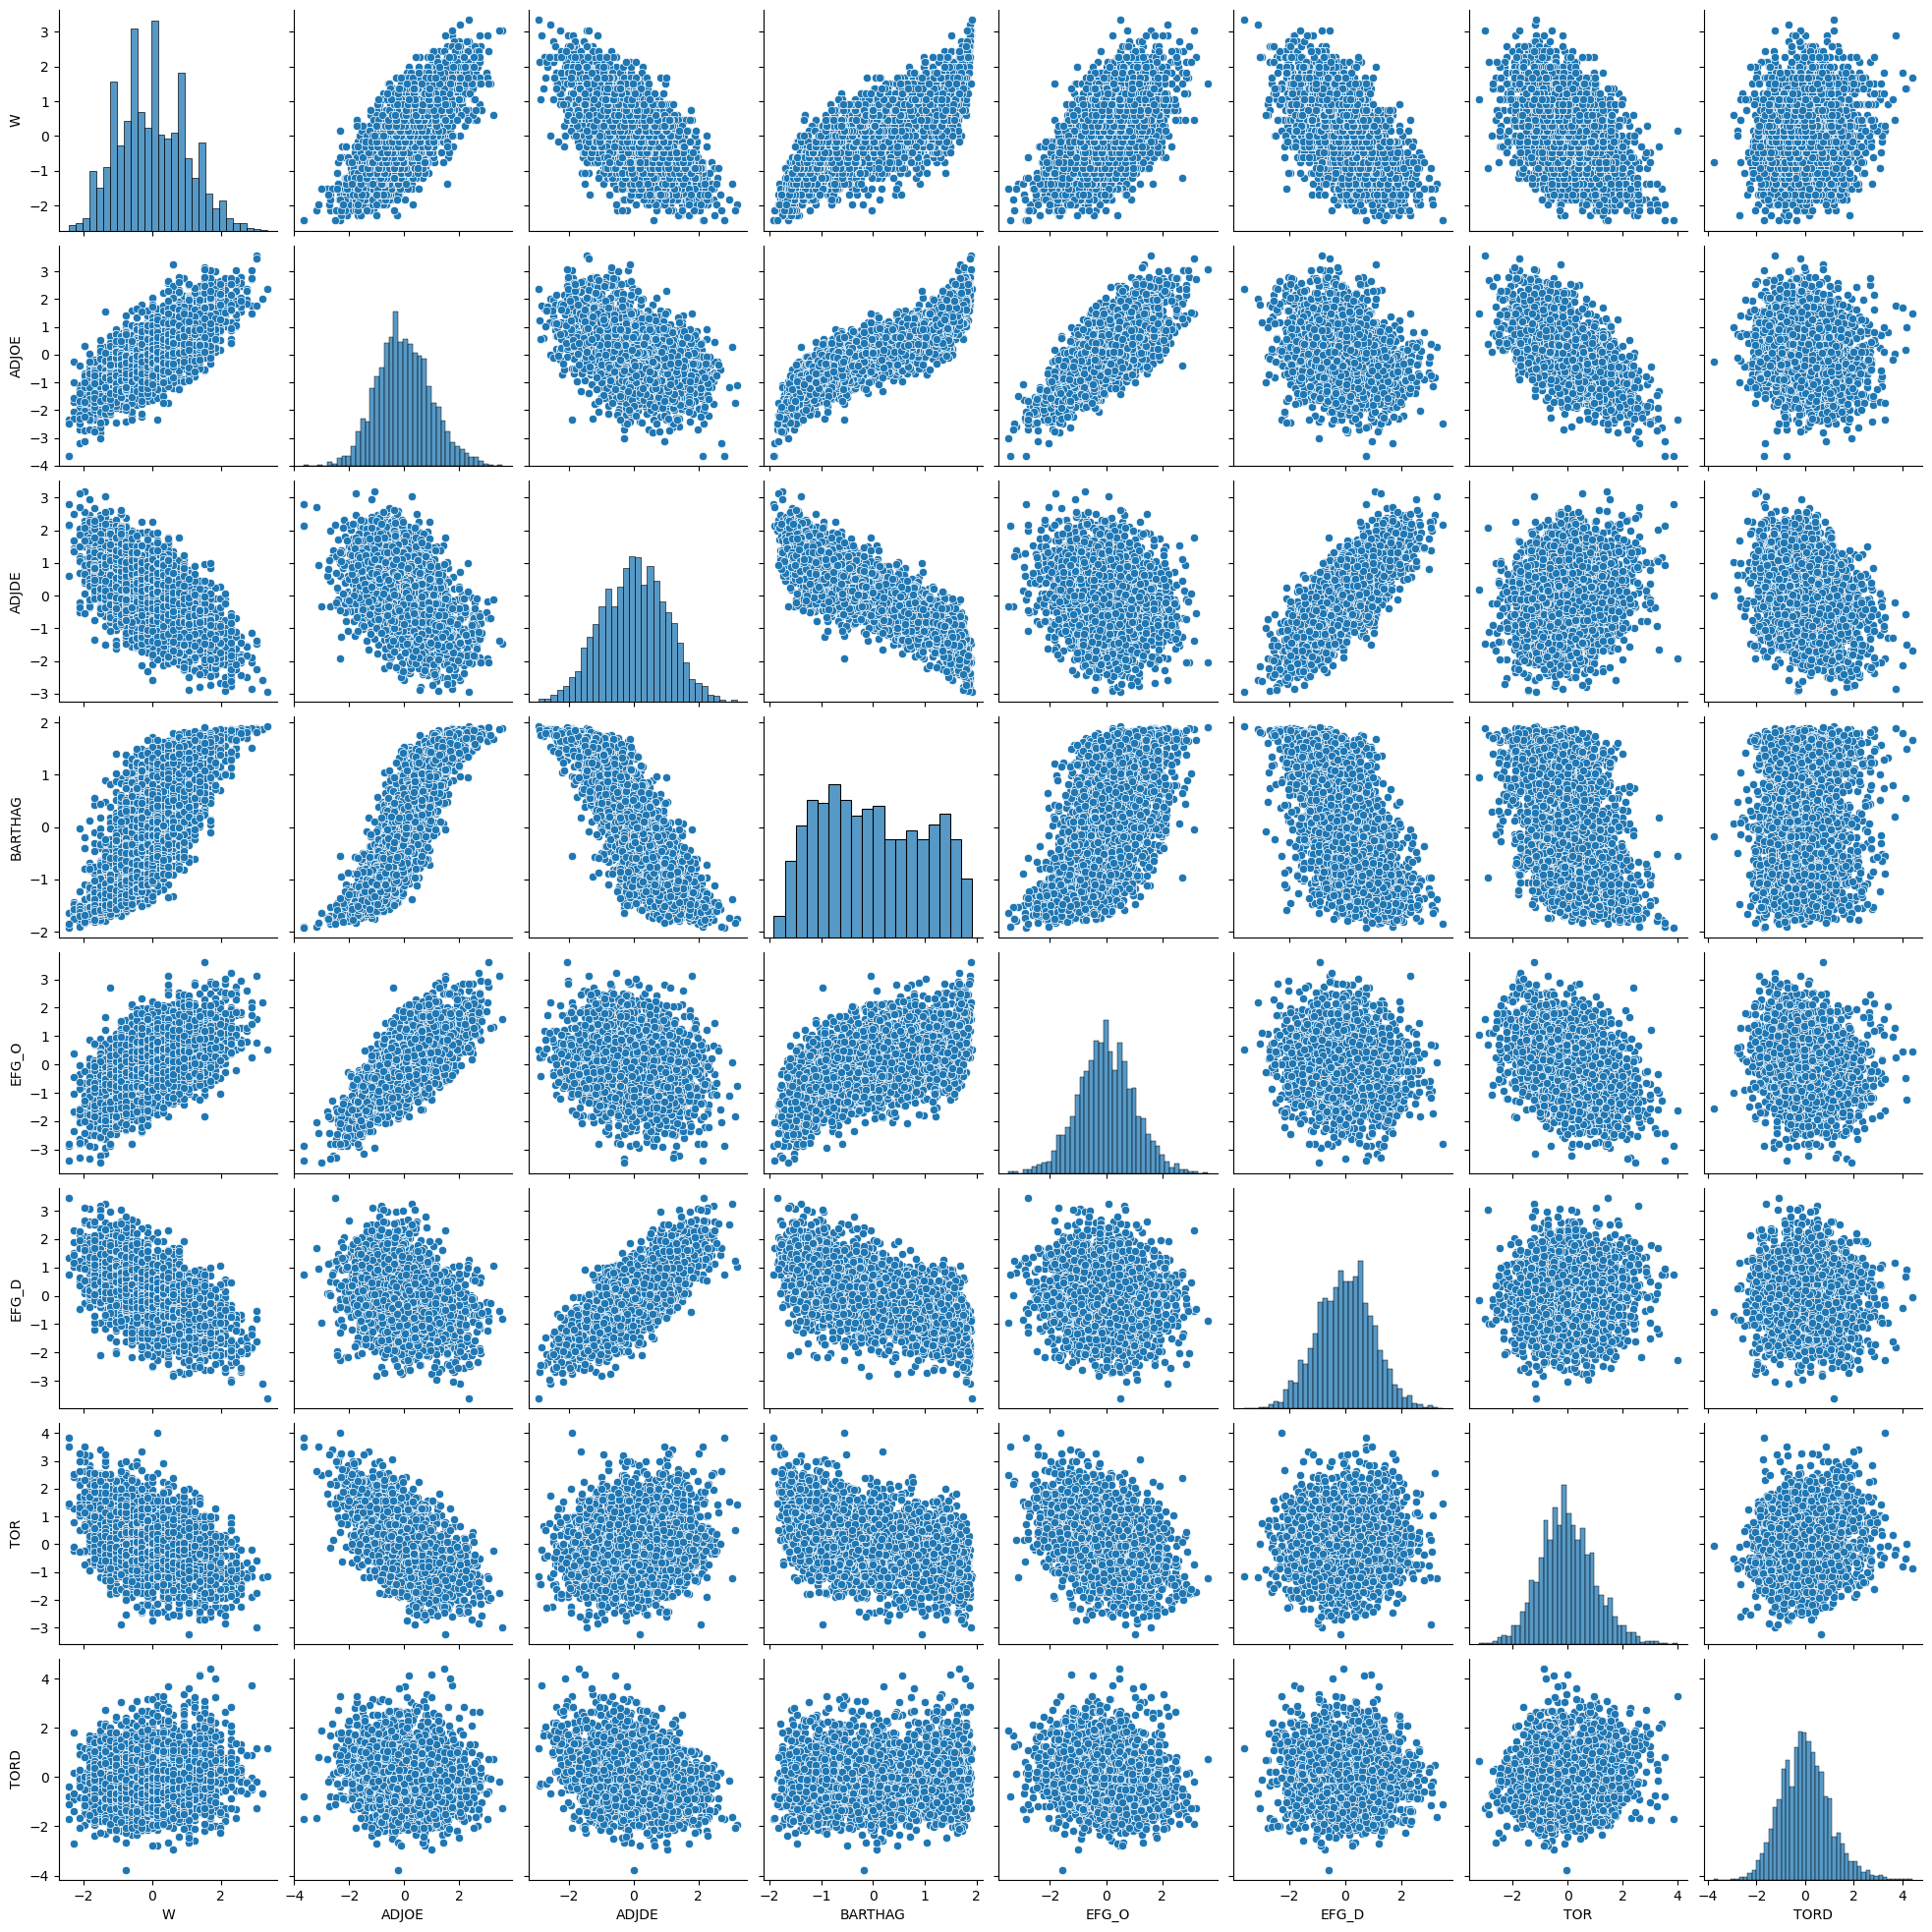

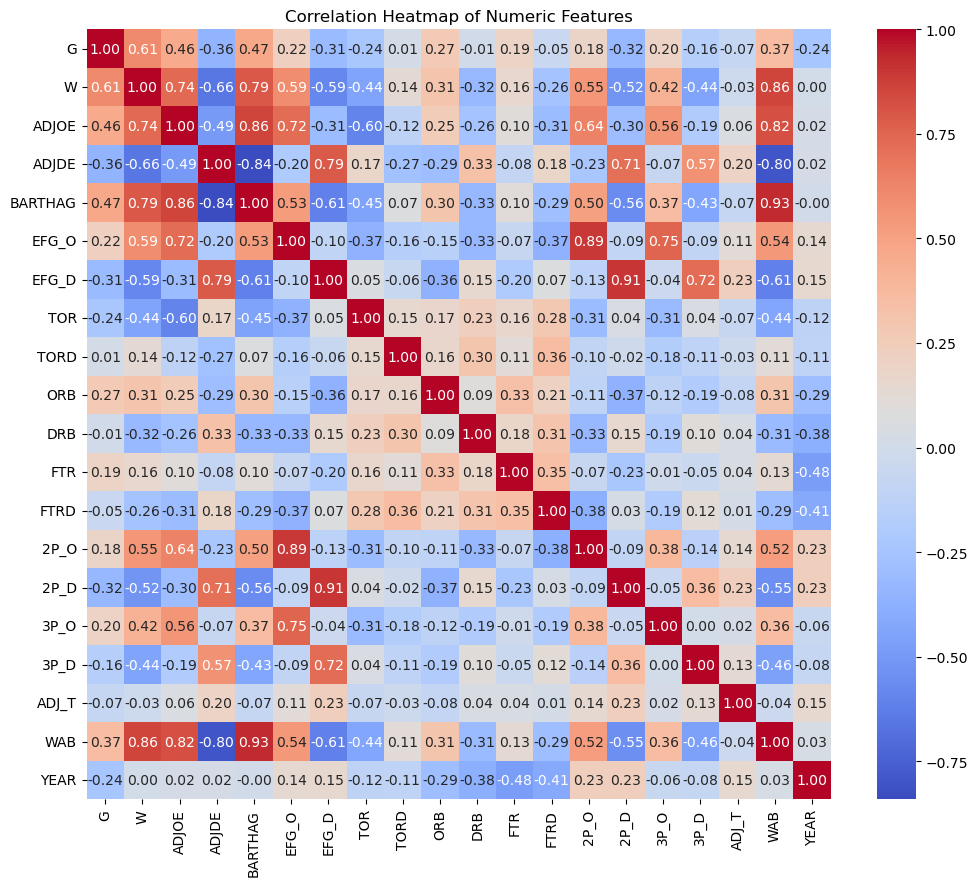

In [8]:
#visualization
numeric_features = ['W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD']
if all(col in basketball_df.columns for col in numeric_features):
    sns.pairplot(basketball_df[numeric_features].dropna())
    plt.show()

#correlation heatmap
numeric_df = basketball_df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
cor = numeric_df.corr()
sns.heatmap(cor, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

##### **Shapiro-Wilk Test** 

Testing for normal distribution

In [9]:
#Normality test using Shapiro-Wilk test
shapiro_results = {}
for var in numerical_vars:
    stat, p = shapiro( basketball_df_numerical[var])
    shapiro_results[var] = {
        'Shapiro-Wilk Statistic': stat,
        'p-value': p,
        'Is Normal': p > 0.05
    }
shapiro_df = pd.DataFrame(shapiro_results).T.sort_values('p-value')
shapiro_df.head(len(shapiro_df))

,Shapiro-Wilk Statistic,p-value,Is Normal
G,0.91468,0.0,False
BARTHAG,0.958721,0.0,False
FTRD,0.985712,0.0,False
W,0.990524,0.0,False
WAB,0.991769,0.0,False
TORD,0.992044,0.0,False
FTR,0.99519,0.0,False
TOR,0.995449,0.0,False
ADJ_T,0.995644,0.0,False
ADJOE,0.997174,0.000004,False


##### **Kruskal Wallace Test**

In [10]:
kruskal_results = []

for var in numerical_vars:
    samples_by_group = []
    for value in set(basketball_df['POSTSEASON']):
        mask = basketball_df['POSTSEASON'] == value
        samples_by_group.append(basketball_df[var][mask])
    
    stat, p_value = kruskal(*samples_by_group)
    
    kruskal_results_dict = {
        'Variable': var,
        'Test Statistic': stat,
        'p-value': p_value,
        'Significant': p_value < (0.05 / len(numerical_vars))  #bonferroni correction
    }
    
    kruskal_results.append(kruskal_results_dict)

kruskal_df = pd.DataFrame(kruskal_results).sort_values('p-value')
kruskal_df.head(len(kruskal_df))


,Variable,Test Statistic,p-value,Significant
18,WAB,1312.405503,4.894586e-278,True
1,W,1196.269200,6.135774e-253,True
4,BARTHAG,1178.193090,4.934498e-249,True
2,ADJOE,994.786253,1.992874e-209,True
3,ADJDE,894.333056,9.423624e-188,True
0,G,672.041358,7.462822e-140,True
6,EFG_D,572.511733,1.893774e-118,True
14,2P_D,452.118644,1.300098e-92,True
5,EFG_O,440.995752,3.140315e-90,True
13,2P_O,386.292923,1.598930e-78,True


##### **Chi-Square Test**

In [11]:
#categorical variable and POSTSEASON
chi2_results = []
for var in categorical_vars:
    combo_counts = pd.crosstab(basketball_df[var], basketball_df['POSTSEASON'])
    chi2, p, _, _ = chi2_contingency(combo_counts)
    chi2_results_dict ={
        'Variable': var,
        'Chi2 Statistic': chi2,
        'p-value': p,
        'Significant': p < (0.05 / len(categorical_vars))  #bonferroni correction
    }
    chi2_results.append(chi2_results_dict)

chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')
chi2_df.head(len(chi2_df))

,Variable,Chi2 Statistic,p-value,Significant
1,POSTSEASON,28184.000000,0.000000e+00,True
2,SEED,6449.853096,0.000000e+00,True
0,CONF,973.094710,1.471978e-79,True
3,YEAR,0.141960,1.000000e+00,False


#### Combine results

In [12]:
#drop non significant variables
kruskal_df = kruskal_df[kruskal_df['Significant'] == True]
chi2_df = chi2_df[chi2_df['Significant'] == True]
#drop postseason variable because it is the target variable
chi2_df = chi2_df[chi2_df['Variable'] != 'POSTSEASON']

#combine the results to one dataframe
#remove the index and test statistics columns
kruskal_df = kruskal_df.drop(columns=['Test Statistic', 'Significant'])
chi2_df = chi2_df.drop(columns=['Chi2 Statistic', 'Significant'])
combined_results = pd.concat([kruskal_df, chi2_df], ignore_index=True)
combined_results = combined_results.sort_values('p-value')
combined_results.head(len(combined_results))

,Variable,p-value
18,SEED,0.000000e+00
0,WAB,4.894586e-278
1,W,6.135774e-253
2,BARTHAG,4.934498e-249
3,ADJOE,1.992874e-209
4,ADJDE,9.423624e-188
5,G,7.462822e-140
6,EFG_D,1.893774e-118
7,2P_D,1.300098e-92
8,EFG_O,3.140315e-90


## **Data modeling and prediction**
development of a predictive model, regression or classification.

### Attempt 1:

In [13]:
label_encoder = LabelEncoder()
basketball_df['POSTSEASON_LABEL'] = label_encoder.fit_transform(basketball_df['POSTSEASON'])

X = basketball_df[numerical_vars]  #
y = basketball_df['POSTSEASON_LABEL']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
    )

#Random Forest with class weighting
rf_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)
test_accuracy = rf_balanced.score(X_test, y_test)

report_df = pd.DataFrame(classification_report(
    y_test, y_pred_balanced, target_names=label_encoder.classes_, output_dict=True)).transpose()
#convert precision, recall, and f1-score to percentages with one decimal
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']] * 100
report_df[['precision', 'recall', 'f1-score', 'support']] = report_df[['precision', 'recall', 'f1-score', 'support']].round(1)

#check for overfitting
train_accuracy = rf_balanced.score(X_train, y_train)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_balanced, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy (mean):", cv_scores.mean())
print("Cross-Validation Accuracy (std):", cv_scores.std())

print("Classification Report (Balanced):")
report_df.head(len(report_df))

c:\Users\burkemperr\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\burkemperr\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\burkemperr\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Training Accuracy: 1.0
Test Accuracy: 0.8448438978240302
Cross-Validation Accuracy (mean): 0.8467180198897932
Cross-Validation Accuracy (std): 0.005142138647666584
Classification Report (Balanced):


,precision,recall,f1-score,support
2ND,0.0,0.0,0.0,3.0
Champions,0.0,0.0,0.0,3.0
E8,0.0,0.0,0.0,12.0
F4,33.3,16.7,22.2,6.0
No Tournament,91.0,99.3,95.0,853.0
R32,33.3,31.2,32.3,48.0
R64,46.0,24.0,31.5,96.0
R68,0.0,0.0,0.0,12.0
S16,30.4,29.2,29.8,24.0
accuracy,84.5,84.5,84.5,0.8


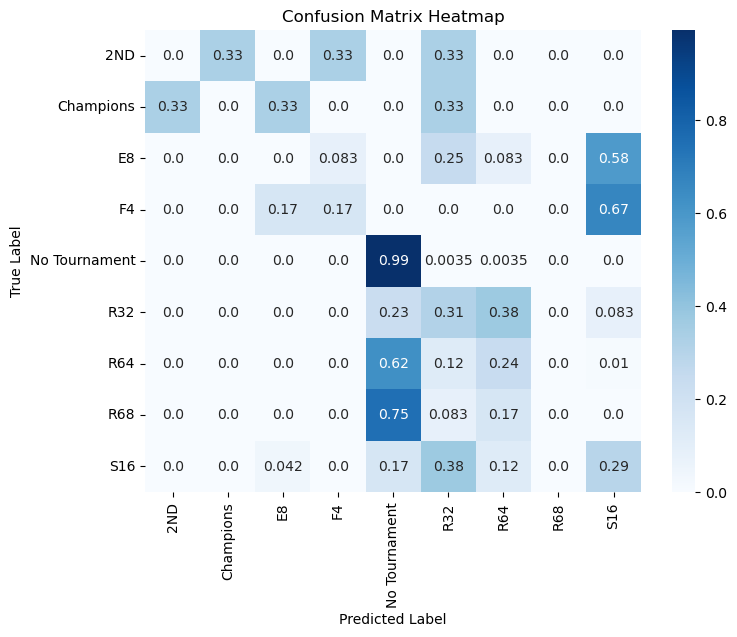

In [14]:
cm = confusion_matrix(y_test, y_pred_balanced)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Group Mapping

In [15]:
group_mapping = {
    'Champions': 'Champion Possible',
    '2ND': 'Champion Possible',
    'F4': 'Champion Possible',
    'S16': 'Runner Up',
    'E8': 'Runner Up',
    'R64': 'Tournament Appearance',
    'R32': 'Tournament Appearance',
    'R68': 'Tournament Appearance',
}

basketball_df['Tournament Grouping'] = basketball_df['POSTSEASON'].map(group_mapping).fillna('No Appearance')
print(basketball_df['Tournament Grouping'].value_counts())
basketball_df.head()

Tournament Grouping
No Appearance            2843
Tournament Appearance     520
Runner Up                 120
Champion Possible          40
Name: count, dtype: int64


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_LABEL,Tournament Grouping
0,North Carolina,ACC,2.407925,2.588173,2.773838,-1.267573,1.798002,0.881130,-0.686500,-1.566916,...,-1.413912,-0.544408,0.751759,1.282537,2.374116,2ND,1.0,2016,0,Champion Possible
1,Wisconsin,B10,2.407925,3.044657,3.572315,-1.467233,1.886916,1.595864,-0.824691,-2.992893,...,-1.383761,0.848146,1.285596,-2.728767,2.770300,2ND,1.0,2015,0,Champion Possible
2,Michigan,B10,2.407925,2.588173,1.548589,-1.958704,1.736898,1.303473,-0.824691,-2.232372,...,-0.750571,0.371746,-0.480172,-0.593718,2.124666,2ND,3.0,2018,0,Champion Possible
3,Texas Tech,B12,1.901727,2.283849,1.658723,-2.757345,1.862631,1.173521,-2.448428,-0.473666,...,-2.228014,0.848146,-1.917426,-0.076130,2.139340,2ND,3.0,2019,0,Champion Possible
4,Gonzaga,WCC,2.154826,3.196819,2.016661,-2.588402,1.875165,2.180646,-3.104833,-1.186655,...,-2.800900,1.471131,-2.204877,1.217839,2.242054,2ND,1.0,2017,0,Champion Possible


### Attempt 2

In [16]:
label_encoder = LabelEncoder()
basketball_df['GROUP_LABEL'] = label_encoder.fit_transform(basketball_df['Tournament Grouping'])
y = basketball_df['GROUP_LABEL']

X = basketball_df[numerical_vars]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#Class-weighted Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
test_accuracy = rf.score(X_test, y_test)

report_df = pd.DataFrame(classification_report(
    y_test, y_pred, target_names=label_encoder.classes_, output_dict=True
)).transpose()
#convert precision, recall, and f1-score to percentages with one decimal
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']] * 100
report_df[['precision', 'recall', 'f1-score', 'support']] = report_df[['precision', 'recall', 'f1-score', 'support']].round(1)

#check for overfitting
train_accuracy = rf.score(X_train, y_train)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy (mean):", cv_scores.mean())
print("Cross-Validation Accuracy (std):", cv_scores.std())
print("Classification Report:")
report_df.head(len(report_df))


Training Accuracy: 1.0
Test Accuracy: 0.8949858088930936
Cross-Validation Accuracy (mean): 0.8974082499117195
Cross-Validation Accuracy (std): 0.011044253500044746
Classification Report:


,precision,recall,f1-score,support
Champion Possible,87.5,58.3,70.0,12.0
No Appearance,93.0,98.2,95.6,853.0
Runner Up,64.3,25.0,36.0,36.0
Tournament Appearance,68.7,59.0,63.4,156.0
accuracy,89.5,89.5,89.5,0.9
macro avg,78.4,60.1,66.3,1057.0
weighted avg,88.4,89.5,88.5,1057.0


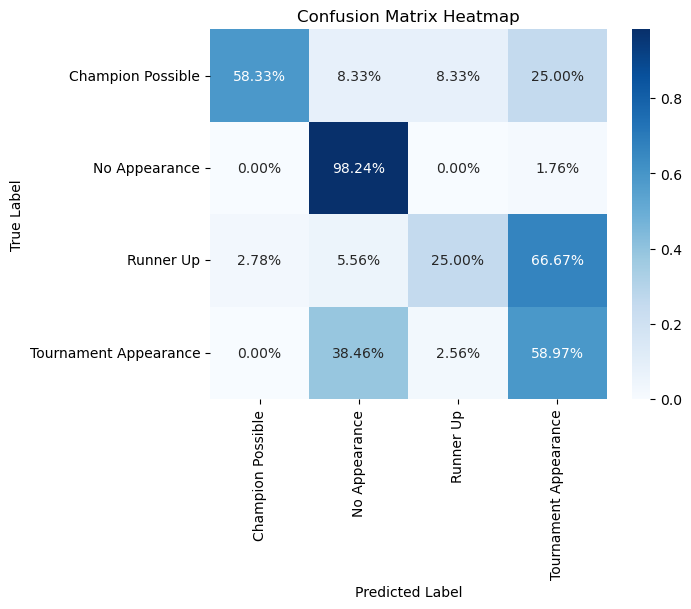

In [17]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = label_encoder.classes_

#heatmap
sns.heatmap(cm_normalized, annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels, cbar=True, cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [18]:
#feature importance
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=numerical_vars).sort_values(ascending=False)
feat_imp.head(len(feat_imp))


G          0.169576
WAB        0.121883
BARTHAG    0.113639
W          0.111304
ADJOE      0.074539
ADJDE      0.046205
EFG_D      0.036353
EFG_O      0.033730
2P_D       0.031649
2P_O       0.028795
FTRD       0.028678
ADJ_T      0.027969
ORB        0.027749
FTR        0.026822
3P_O       0.026676
DRB        0.025072
3P_D       0.024853
TOR        0.023386
TORD       0.021123
dtype: float64

### Attempt 3

In [19]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8, 9, 10, None],  #unlimited depth (None)
    'n_estimators': [100], 
    'class_weight': ['balanced']
}
rf = RandomForestClassifier(random_state=42)

#grid search with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8974082499117195


In [20]:
#train on only top 5 features
#top_features = feat_imp.head(5).index.tolist()

label_encoder = LabelEncoder()
basketball_df['GROUP_LABEL'] = label_encoder.fit_transform(basketball_df['Tournament Grouping'])
y = basketball_df['GROUP_LABEL']

X = basketball_df[numerical_vars]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#Class-weighted Random Forest
#rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=6)
rf = RandomForestClassifier(
    class_weight='balanced', 
    max_depth=None, 
    n_estimators=100, 
    random_state=42
)
rf.fit(X_train, y_train)
#y_pred = rf.predict(X_test)

y_pred = rf.predict(X_test)
test_accuracy = rf.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

report_df = pd.DataFrame(classification_report(
    y_test, y_pred, target_names=label_encoder.classes_, output_dict=True
)).transpose()
#convert precision, recall, and f1-score to percentages with one decimal
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']] * 100
report_df[['precision', 'recall', 'f1-score', 'support']] = report_df[['precision', 'recall', 'f1-score', 'support']].round(1)

#check for overfitting
train_accuracy = rf.score(X_train, y_train)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy (mean):", cv_scores.mean())
print("Cross-Validation Accuracy (std):", cv_scores.std())
print("Classification Report:")
report_df.head(len(report_df))


Test Accuracy: 0.8949858088930936
Training Accuracy: 1.0
Test Accuracy: 0.8949858088930936
Cross-Validation Accuracy (mean): 0.8974082499117195
Cross-Validation Accuracy (std): 0.011044253500044746
Classification Report:


,precision,recall,f1-score,support
Champion Possible,87.5,58.3,70.0,12.0
No Appearance,93.0,98.2,95.6,853.0
Runner Up,64.3,25.0,36.0,36.0
Tournament Appearance,68.7,59.0,63.4,156.0
accuracy,89.5,89.5,89.5,0.9
macro avg,78.4,60.1,66.3,1057.0
weighted avg,88.4,89.5,88.5,1057.0


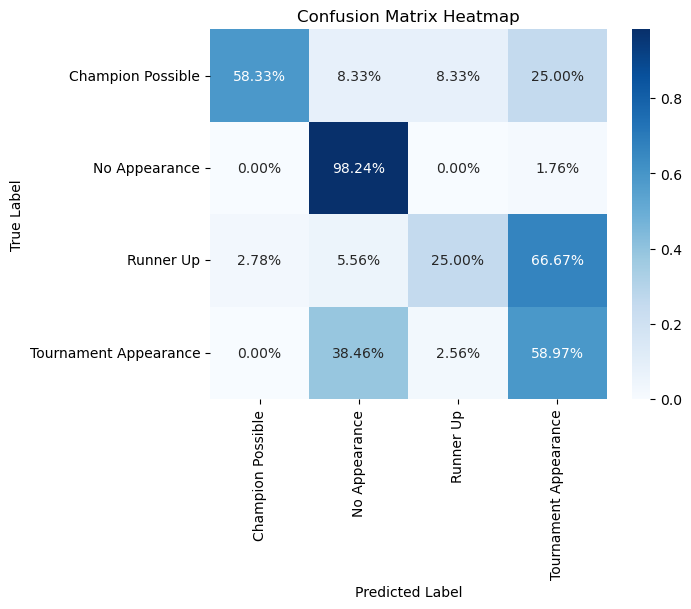

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = label_encoder.classes_

#heatmap
sns.heatmap(cm_normalized, annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels, cbar=True, cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Attempt 4

In [22]:
#train on only top 5 features
#top_features = feat_imp.head(5).index.tolist()

label_encoder = LabelEncoder()
basketball_df['GROUP_LABEL'] = label_encoder.fit_transform(basketball_df['Tournament Grouping'])
y = basketball_df['GROUP_LABEL']

X = basketball_df[numerical_vars]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#Class-weighted Random Forest
#rf = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=6)
rf = RandomForestClassifier(
    max_depth=5, 
    random_state=42
)
rf.fit(X_train, y_train)
#y_pred = rf.predict(X_test)

y_pred = rf.predict(X_test)
test_accuracy = rf.score(X_test, y_test)

report_df = pd.DataFrame(classification_report(
    y_test, y_pred, target_names=label_encoder.classes_, output_dict=True
)).transpose()
#convert precision, recall, and f1-score to percentages with one decimal
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']] * 100
report_df[['precision', 'recall', 'f1-score', 'support']] = report_df[['precision', 'recall', 'f1-score', 'support']].round(1)

#check for overfitting
train_accuracy = rf.score(X_train, y_train)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy (mean):", cv_scores.mean())
print("Cross-Validation Accuracy (std):", cv_scores.std())

print("Classification Report:")
report_df.head(len(report_df))



Training Accuracy: 0.9184914841849149
Test Accuracy: 0.8959318826868495
Cross-Validation Accuracy (mean): 0.9026771563015824
Cross-Validation Accuracy (std): 0.012298497128243907
Classification Report:


,precision,recall,f1-score,support
Champion Possible,100.0,25.0,40.0,12.0
No Appearance,93.1,98.6,95.8,853.0
Runner Up,57.1,22.2,32.0,36.0
Tournament Appearance,69.3,60.9,64.8,156.0
accuracy,89.6,89.6,89.6,0.9
macro avg,79.9,51.7,58.2,1057.0
weighted avg,88.5,89.6,88.4,1057.0


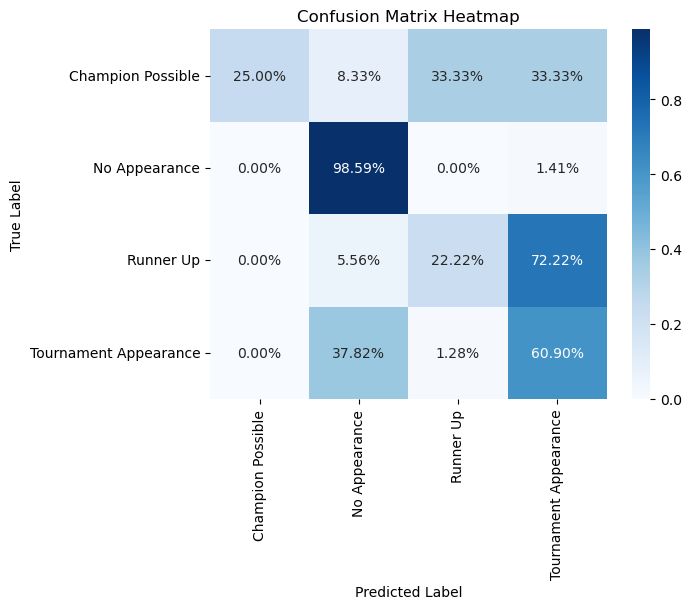

In [23]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = label_encoder.classes_

#heatmap
sns.heatmap(cm_normalized, annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels, cbar=True, cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
